In [2]:
import pandas as pd
import xlrd
from matplotlib import pyplot as plt
import numpy as np
import openpyxl
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math
from sklearn.svm import SVR

In [3]:
data=pd.read_excel('E9367CD7-C9BA-4C8B-86C9-53837D81AD49.Bitcoin Historical Data (1).xlsx')
data.head()

,Date,DATE,Price,Open,High,Low,Vol.,Change %,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,ETH Vol.,OIL Price Adjusted,Days from the last halving,BTC_Hashprice,Crypto Volatility Index,Target Value
0,04/21/2024,2024-04-21,64902.8,64942.1,65680.6,64618.4,45.17K,-0.0009,4953.56,105.984,2390.45,3169.62,276.66K,83.14,2,0.000003,75.1890,0
1,04/20/2024,2024-04-20,64961.1,63817.6,65375.6,63131.7,49.33K,0.0182,4953.56,105.984,2390.45,3156.63,256.05K,83.14,1,0.000002,74.3407,0
2,04/19/2024,2024-04-19,63799.1,63480.5,65441.2,59693.3,150.34K,0.0050,4953.56,105.984,2390.45,3056.23,645.65K,83.14,1439,0.000002,73.6438,0
3,04/18/2024,2024-04-18,63481.4,61278.9,64092.4,60822.3,97.38K,0.0359,5001.89,105.982,2378.25,3064.48,423.99K,82.73,1438,0.000002,72.4399,1
4,04/17/2024,2024-04-17,61278.9,63802.3,64451.5,59820.8,118.92K,-0.0396,5007.25,105.764,2360.81,2985.82,524.88K,82.69,1437,0.000002,74.0805,1


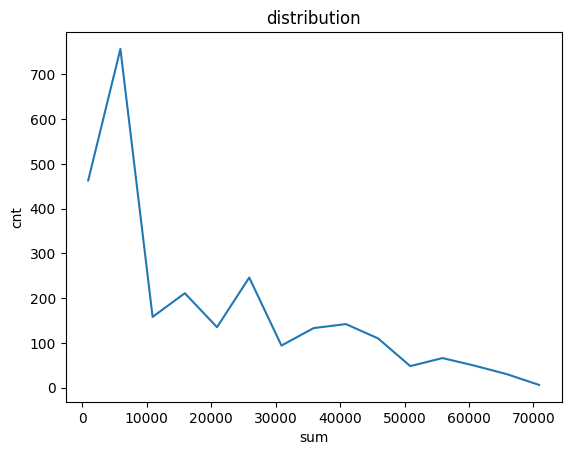

In [4]:
price=data['Price']
minPrice=price.min()
maxPrice=price.max()
step = 5000
xpoints = np.arange(minPrice, maxPrice+step,step) #כל הספרות בדילוגים של 500
# חישוב תדירות לכל טווח מחיר
hist, bins = np.histogram(price, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="Price")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.show()

In [5]:
min_val = int(0)
max_val = int(data['Price'].max())
data.Price=data.Price.astype(int)
ranges = list(range(min_val, max_val + 5000, 5000))
data['ranges_price'] = pd.cut(data['Price'], bins=ranges, labels=[f"{r}-{r+4999}" for r in ranges[:-1]])
# print(data.ranges_price)


import copy
df_Price = copy.deepcopy(data)

df_Price['Price'] = df_Price['Price'].astype(int)
grouped_data = (
    df_Price.pivot_table(
        index='ranges_price',
        values=['Price', 'Target Value'],
                aggfunc={'Price': 'count','Target Value': ['sum', 'mean']},

    ).reset_index()
)
print(grouped_data)


   ranges_price Price Target Value     
                count         mean  sum
0        0-4999   402     0.363184  146
1     5000-9999   717     0.299861  215
2   10000-14999   244     0.331967   81
3   15000-19999   183     0.251366   46
4   20000-24999   165     0.260606   43
5   25000-29999   219     0.178082   39
6   30000-34999   108     0.287037   31
7   35000-39999   140     0.357143   50
8   40000-44999   152     0.263158   40
9   45000-49999   107     0.327103   35
10  50000-54999    51     0.352941   18
11  55000-59999    67     0.328358   22
12  60000-64999    52     0.326923   17
13  65000-69999    32     0.406250   13
14  70000-74999     9     0.222222    2


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\3001503019.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Price.pivot_table(


In [6]:
print("------Consolidation of variables------")

data["Price_final_range"]= np.where(data["Price"]<=24999,"less24999",np.where(data["Price"] > 45000,"grater45000","24999-45000"))
data_new1=data.loc[:,["Price","Price_final_range"]]
data_new1.head(100)

------Consolidation of variables------


,Price,Price_final_range
0,64902,grater45000
1,64961,grater45000
2,63799,grater45000
3,63481,grater45000
4,61278,grater45000
...,...,...
95,42768,24999-45000
96,43145,24999-45000
97,42510,24999-45000
98,41746,24999-45000


In [7]:
df_Price_final_range = (
    data.pivot_table(
        index='Price_final_range',
        values=['Price', 'Target Value'],
                aggfunc={'Price': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_Price_final_range)

  Price_final_range Price Target Value     
                    count         mean  sum
0       24999-45000   619     0.258481  160
1       grater45000   318     0.336478  107
2         less24999  1711     0.310345  531


In [8]:
data['Vol.'] = data['Vol.'].str.replace('[a-zA-Z]', '', regex=True)
data['Vol.'] = pd.to_numeric(data['Vol.'])
print(data['Vol.'])
Vol=data['Vol.']


0        45.17
1        49.33
2       150.34
3        97.38
4       118.92
         ...  
2643     37.90
2644     58.87
2645     32.74
2646     47.93
2647     40.38
Name: Vol., Length: 2648, dtype: float64


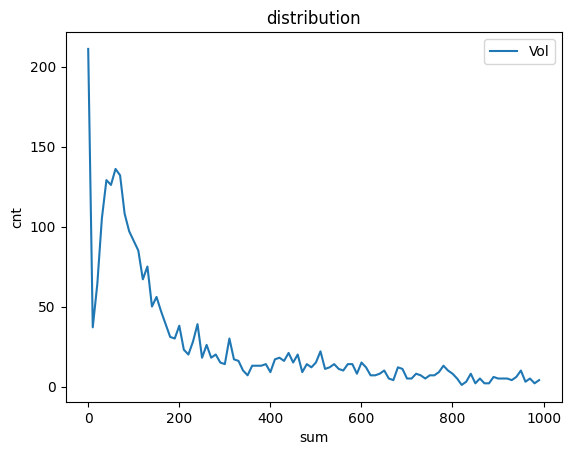

In [9]:
minVol=Vol.min()
maxVol=Vol.max()
step = 10
xpoints = np.arange(minVol, maxVol + step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(Vol, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="Vol")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [10]:
min_val = int(data['Vol.'].min())
max_val = int(data['Vol.'].max())
ranges = list(range(min_val, max_val + 100, 100)) 
data['ranges_Vol'] = pd.cut(data['Vol.'], bins=ranges, labels=[f"{r}-{r+99}" for r in ranges[:-1]])
# print(data['ranges_Vol'])
import copy
df_Vol = copy.deepcopy(data)

grouped_data = df_Vol.pivot_table( 
    index='ranges_Vol',
    values=['Vol.', 'Target Value'], 
    aggfunc={'Vol.': 'count', 'Target Value': ['sum', 'mean']}, )

print(grouped_data)


           Target Value       Vol.
                   mean  sum count
ranges_Vol                        
0-99           0.220859  252  1141
100-199        0.431304  248   575
200-299        0.412245  101   245
300-399        0.321918   47   146
400-499        0.171053   26   152
500-599        0.207692   27   130
600-699        0.336957   31    92
700-799        0.328947   25    76
800-899        0.380952   16    42
900-999        0.510204   25    49


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\3268698819.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_Vol.pivot_table(


In [11]:
data["Vol_final_range"]= np.where(data["Vol."]<=400,"less400",np.where(data["Vol."] > 600, "getter600","400-600"))
data_new=data.loc[:,["Vol.","Vol_final_range"]]


In [12]:
Vol_final_range = (
    data.pivot_table(
        index='Vol_final_range',
        values=['Vol.', 'Target Value'],
                aggfunc={'Vol.': 'count','Target Value': ['sum', 'mean']},).reset_index())
# # הצג את הטבלה החדשה
print(Vol_final_range)

  Vol_final_range Target Value       Vol.
                          mean  sum count
0         400-600     0.187943   53   282
1       getter600     0.374517   97   259
2         less400     0.307546  648  2107


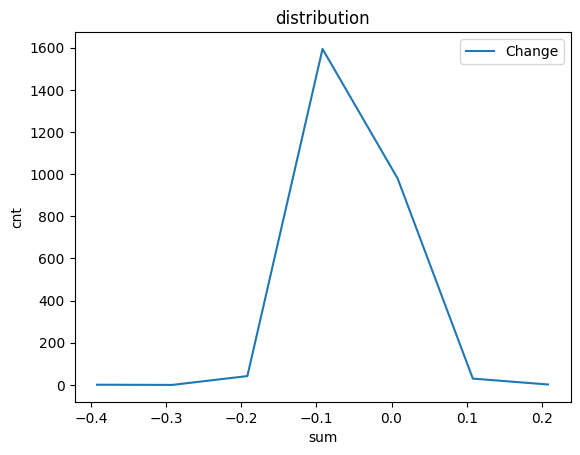

In [13]:
change=data['Change %']
minChange=change.min()
maxChange=change.max()
step = 0.1
xpoints = np.arange(minChange, maxChange+step,step) 
hist, bins = np.histogram(change, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="Change")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [14]:
data["Change %"] = data["Change %"]
df = pd.DataFrame(data)
# עיגול הערכים בעמודה "Change %" לשתי ספרות אחרי הנקודה
df['Change %'] = df['Change %'].round(2)
# print(df['Change %'])
min_val_Change = np.min(df['Change %'])
max_val_Change = np.max(df['Change %'])
Change = np.arange(min_val_Change, max_val_Change + 0.01, 0.01)
labels = [f"{r:.2f}-{r+(-0.99):.2f}" for r in Change[:-1]]
data['ranges_Change'] = pd.cut(df['Change %'], bins=Change, labels=labels)

print(data['ranges_Change'])

import copy
df_Vol = copy.deepcopy(data)

grouped_data = df_Vol.pivot_table( 
    index='ranges_Change',
    values=['Change %', 'Target Value'], 
    aggfunc={'Change %': 'count', 'Target Value': ['sum', 'mean']}, )

print(grouped_data)


0       -0.01--1.00
1        0.01--0.98
2       -0.01--1.00
3        0.03--0.96
4       -0.05--1.04
           ...     
2643    -0.01--1.00
2644    -0.04--1.03
2645    -0.01--1.00
2646    -0.01--1.00
2647     0.02--0.97
Name: ranges_Change, Length: 2648, dtype: category
Categories (65, object): ['-0.39--1.38' < '-0.38--1.37' < '-0.37--1.36' < '-0.36--1.35' ... '0.22--0.77' < '0.23--0.76' < '0.24--0.75' < '0.25--0.74']
              Change % Target Value    
                 count         mean sum
ranges_Change                          
-0.39--1.38          0          NaN   0
-0.38--1.37          0          NaN   0
-0.37--1.36          0          NaN   0
-0.36--1.35          0          NaN   0
-0.35--1.34          0          NaN   0
...                ...          ...  ..
0.21--0.78           0          NaN   0
0.22--0.77           1          1.0   1
0.23--0.76           0          NaN   0
0.24--0.75           0          NaN   0
0.25--0.74           1          1.0   1

[65 rows x 3 colu

C:\Users\user1\AppData\Local\Temp\ipykernel_106608\1390758164.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_Vol.pivot_table(


In [15]:
print("------Consolidation of variables------")

data["Change_final_range"]= np.where(data["Change %"]<=69,"less69",np.where(data["Change %"] > 100,"grater100","69-100"))
df_new2=data.loc[:,["Change %","Change_final_range"]]
df_new2.head(200)


------Consolidation of variables------


,Change %,Change_final_range
0,-0.0009,less69
1,0.0182,less69
2,0.0050,less69
3,0.0359,less69
4,-0.0396,less69
...,...,...
195,-0.0122,less69
196,-0.0014,less69
197,0.0009,less69
198,0.0192,less69


In [16]:
df_Change_final_range = (
    data.pivot_table(
        index='Change_final_range',
        values=['Change %', 'Target Value'],
                aggfunc={'Change %': 'count','Target Value': ['sum', 'mean']},).reset_index())
# # הצג את הטבלה החדשה
print(df_Change_final_range)

  Change_final_range Change % Target Value     
                        count         mean  sum
0             less69     2648      0.30136  798


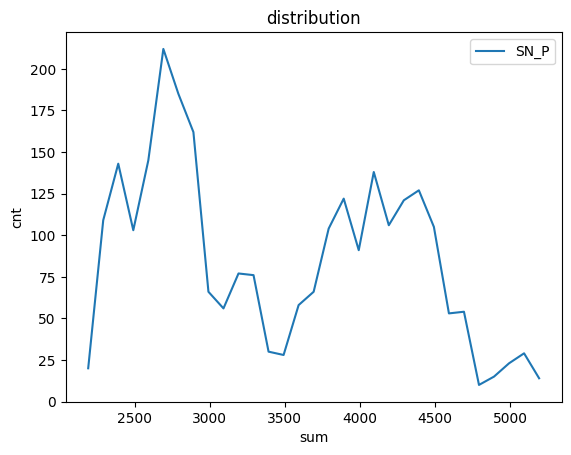

In [17]:
SN_P=data['SN&P Adjusted']
minSN_P=SN_P.min()
maxSN_P=SN_P.max()
step = 100
xpoints = np.arange(minSN_P, maxSN_P+step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(SN_P, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="SN_P")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [18]:
# SN&P Adjusted
min_val = int(data['SN&P Adjusted'].min())
max_val = int(data['SN&P Adjusted'].max())
ranges = list(range(min_val, max_val + 500, 500))
data['ranges_SN&P_Adjusted'] = pd.cut(data['SN&P Adjusted'], bins=ranges, labels=[f"{r}-{r+499}" for r in ranges[:-1]])
# print(data['ranges_SN&P_Adjusted'])
df_SNP_Adjusted = data.copy()

grouped_data = df_SNP_Adjusted.pivot_table(
    index='ranges_SN&P_Adjusted',
    values=['SN&P Adjusted', 'Target Value'],
    aggfunc={'SN&P Adjusted': 'count', 'Target Value': ['sum', 'mean']},
)

print(grouped_data)

print("------Consolidation of variables------")


df["SN&P_Adjusted_final_range"]= np.where(df["SN&P Adjusted"]<=2690,"less2690","grater2690")
df_new3=df.loc[:,["SN&P Adjusted","SN&P_Adjusted_final_range"]]
# print(df_new3.head(200))


df_SNP_Adjusted_final_range = (
    df.pivot_table(
        index='SN&P_Adjusted_final_range',
        values=['SN&P Adjusted', 'Target Value'],
                aggfunc={'SN&P Adjusted': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_SNP_Adjusted_final_range)


                     SN&P Adjusted Target Value     
                             count         mean  sum
ranges_SN&P_Adjusted                                
2191-2690                      519     0.441233  229
2691-3190                      681     0.280470  191
3191-3690                      270     0.214815   58
3691-4190                      521     0.295585  154
4191-4690                      512     0.244141  125
4691-5190                      131     0.282443   37
5191-5690                       14     0.285714    4
------Consolidation of variables------
  SN&P_Adjusted_final_range SN&P Adjusted Target Value     
                                    count         mean  sum
0                grater2690          2129     0.267262  569
1                  less2690           519     0.441233  229


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\818789007.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_SNP_Adjusted.pivot_table(


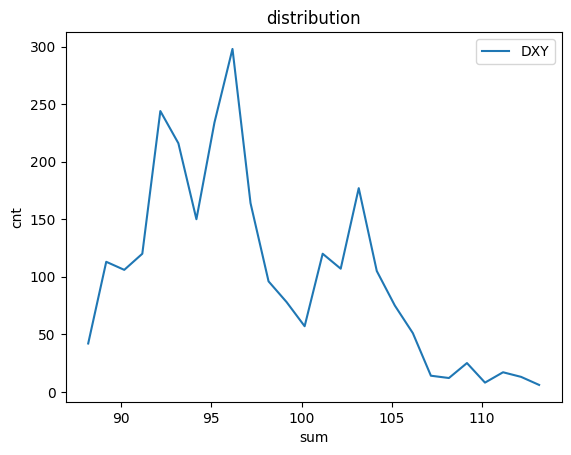

In [19]:
DXY=data['DXY Adjusted']
minDXY=DXY.min()
maxDXY=DXY.max()
step = 1
xpoints = np.arange(minDXY, maxDXY+step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(DXY, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="DXY")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [20]:
# DXY
min_val = int(data['DXY Adjusted'].min())
max_val = int(data['DXY Adjusted'].max())
ranges = list(range(min_val, max_val + 10, 10)) 
data['ranges_DXY_Adjusted'] = pd.cut(data['DXY Adjusted'], bins=ranges, labels=[f"{r}-{r+1}" for r in ranges[:-1]])
# print(data['ranges_DXY_Adjusted']) 
df_DXY_Adjusted = copy.deepcopy(data)

grouped_data = df_DXY_Adjusted.pivot_table( 
    index='ranges_DXY_Adjusted',
    values=['DXY Adjusted', 'Target Value'], 
    
    aggfunc={'DXY Adjusted': 'count', 'Target Value': ['sum', 'mean']}, )

# הצגת 
print(grouped_data)

                    DXY Adjusted Target Value     
                           count         mean  sum
ranges_DXY_Adjusted                               
88-89                       1675     0.346269  580
98-99                        888     0.228604  203
108-109                       85     0.176471   15


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\2713385260.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_DXY_Adjusted.pivot_table(


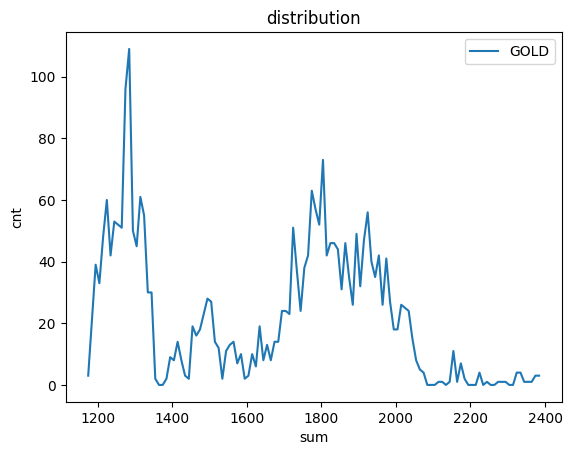

In [21]:
GOLD=data['GOLD Adjusted']
minGOLD=GOLD.min()
maxGOLD=GOLD.max()
step = 10
xpoints = np.arange(minGOLD, maxGOLD+step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(GOLD, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="GOLD")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [22]:
# עמודת זהב, GOLD
min_val = int(data['GOLD Adjusted'].min())
max_val = int(data['GOLD Adjusted'].max())
print(min_val)
print(max_val)
ranges = list(range(min_val, max_val + 100, 100))
data['ranges_GOLD_Adjusted'] = pd.cut(data['GOLD Adjusted'], bins=ranges, labels=[f"{r}-{r+99}" for r in ranges[:-1]])
# print(data.ranges_GOLD_Adjusted)
import copy
dfGold = copy.deepcopy(data)

# dfGold['GOLD Adjusted'] = dfGold['GOLD Adjusted'].astype(int)
grouped_data = dfGold.pivot_table( 
    index='ranges_GOLD_Adjusted',
    values=['GOLD Adjusted', 'Target Value'],    
    aggfunc={'GOLD Adjusted': 'count', 'Target Value': ['sum', 'mean']}, )

print(grouped_data)

1174
2390
                     GOLD Adjusted Target Value     
                             count         mean  sum
ranges_GOLD_Adjusted                                
1174-1273                      401     0.349127  140
1274-1373                      479     0.382046  183
1374-1473                       81     0.407407   33
1474-1573                      162     0.265432   43
1574-1673                       86     0.220930   19
1674-1773                      288     0.298611   86
1774-1873                      503     0.290258  146
1874-1973                      388     0.224227   87
1974-2073                      207     0.198068   41
2074-2173                       19     0.421053    8
2174-2273                       14     0.214286    3
2274-2373                       14     0.500000    7
2374-2473                        6     0.333333    2


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\684452676.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = dfGold.pivot_table(


In [23]:
data["GOLD_Adjusted_final_rangee"] = np.where(data["GOLD Adjusted"]<=1437,"less1437",np.where(data["GOLD Adjusted"]<=2073,"1437-2973","greater2937"))
df_new3 = data.loc[:, ["GOLD Adjusted", "GOLD_Adjusted_final_rangee"]]
# print(df_new3)


df_GOLD_Adjusted_final_range = data.pivot_table(
    index='GOLD_Adjusted_final_rangee',
    values=['GOLD Adjusted', 'Target Value'],
    aggfunc={'GOLD Adjusted': 'count', 'Target Value': ['sum', 'mean']}
).reset_index()

print(df_GOLD_Adjusted_final_range)

  GOLD_Adjusted_final_rangee GOLD Adjusted Target Value     
                                     count         mean  sum
0                  1437-2973          1674     0.258662  433
1                greater2937            53     0.377358   20
2                   less1437           921     0.374593  345


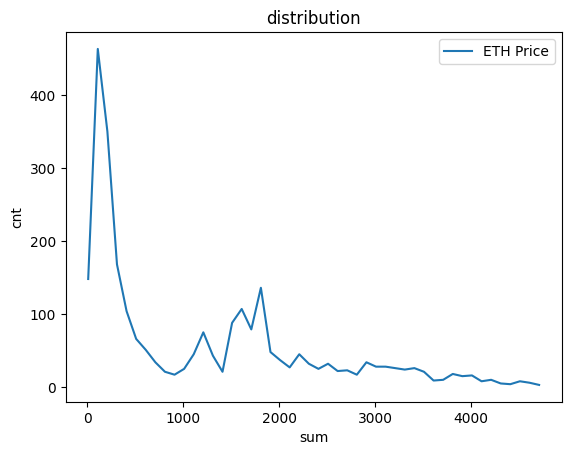

In [24]:
ETH=data['ETH Price']
minETH=ETH.min()
maxETH=ETH.max()
step = 100
xpoints = np.arange(minETH, maxETH+step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(ETH, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="ETH Price")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [25]:
# ETH Price
min_val = int(data['ETH Price'].min())
max_val = int(data['ETH Price'].max())
ranges = list(range(min_val, max_val + 500, 500)) 
data['ranges_ETH_Price'] = pd.cut(data['ETH Price'], bins=ranges, labels=[f"{r}-{r+499}" for r in ranges[:-1]])
print(data['ranges_ETH_Price'])
df_ETH_Price = copy.deepcopy(data)

grouped_data = df_ETH_Price.pivot_table( 
    index='ranges_ETH_Price',
    values=['ETH Price', 'Target Value'], 
    
    aggfunc={'ETH Price': 'count', 'Target Value': ['sum', 'mean']}, )

print(grouped_data)

0       3010-3509
1       3010-3509
2       3010-3509
3       3010-3509
4       2510-3009
          ...    
2643       10-509
2644       10-509
2645       10-509
2646       10-509
2647       10-509
Name: ranges_ETH_Price, Length: 2648, dtype: category
Categories (10, object): ['10-509' < '510-1009' < '1010-1509' < '1510-2009' ... '3010-3509' < '3510-4009' < '4010-4509' < '4510-5009']
                 ETH Price Target Value     
                     count         mean  sum
ranges_ETH_Price                            
10-509                1233     0.304136  375
510-1009               189     0.486772   92
1010-1509              209     0.282297   59
1510-2009              458     0.211790   97
2010-2509              166     0.295181   49
2510-3009              128     0.351562   45
3010-3509              132     0.272727   36
3510-4009               73     0.369863   27
4010-4509               43     0.348837   15
4510-5009               17     0.176471    3


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\2084327974.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_ETH_Price.pivot_table(


In [26]:
df_ETH_Price_no_nan= data.loc[:, ['ETH Price', 'Target Value']].dropna()
df_ETH_Price_no_nan.isnull().sum()
df_ETH_Price_no_nan.head(10)

df["ETH_Price_final_range"]= np.where(df["ETH Price"]<=1009,"less1009",np.where(df["ETH Price"]>4510,"grater1474","1009-4509"))

df_new3=df.loc[:,["ETH Price","ETH_Price_final_range"]]

df_ETH_Price_final_range = (
    df.pivot_table(
        index='ETH_Price_final_range',
        values=['ETH Price', 'Target Value'],
                aggfunc={'ETH Price': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_ETH_Price_final_range)

  ETH_Price_final_range ETH Price Target Value     
                            count         mean  sum
0             1009-4509      1209     0.271299  328
1            grater1474        17     0.176471    3
2              less1009      1422     0.328411  467


In [27]:
data['ETH Vol.'] = data['ETH Vol.'].str.replace('[a-zA-Z]', '', regex=True)
data['ETH Vol.'] = pd.to_numeric(data['ETH Vol.'])
print(data['ETH Vol.'])

0       276.66
1       256.05
2       645.65
3       423.99
4       524.88
         ...  
2643     26.19
2644    105.21
2645     54.39
2646    140.66
2647    125.31
Name: ETH Vol., Length: 2648, dtype: float64


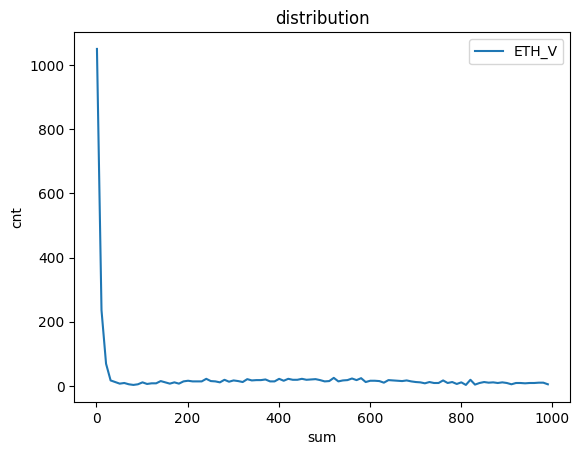

In [28]:
ETH_V=data['ETH Vol.']
minETH_V=ETH_V.min()
maxETH_V=ETH_V.max()
step = 10
xpoints = np.arange(minETH_V, maxETH_V + step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(ETH_V, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="ETH_V")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [29]:
data['ETH Vol.'] = pd.to_numeric(data['ETH Vol.'])
print(data['ETH Vol.'])


0       276.66
1       256.05
2       645.65
3       423.99
4       524.88
         ...  
2643     26.19
2644    105.21
2645     54.39
2646    140.66
2647    125.31
Name: ETH Vol., Length: 2648, dtype: float64


In [30]:
min_val = int(data['ETH Vol.'].min())
max_val = int(data['ETH Vol.'].max())
ranges = list(range(min_val, max_val + 100, 100)) 
data['ranges_ETH_Vol'] = pd.cut(data['ETH Vol.'], bins=ranges, labels=[f"{r}-{r+99}" for r in ranges[:-1]])
import copy
df_ETH_Vol= copy.deepcopy(data)



In [31]:


grouped_data = df_ETH_Vol.pivot_table( 
    index='ranges_ETH_Vol',
    values=['ETH Vol.', 'Target Value'],     
    aggfunc={'ETH Vol.': 'count', 'Target Value': ['sum', 'mean']}, 
)

print(grouped_data)

               ETH Vol. Target Value     
                  count         mean  sum
ranges_ETH_Vol                           
1-100              1410     0.337589  476
101-200              98     0.122449   12
201-300             152     0.105263   16
301-400             166     0.108434   18
401-500             198     0.227273   45
501-600             180     0.388889   70
601-700             154     0.331169   51
701-800             105     0.333333   35
801-900              99     0.393939   39
901-1000             83     0.421687   35


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\106644665.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_ETH_Vol.pivot_table(


In [32]:

print("------Consolidation of variables------")

data["ETH_Vol_final_range"]= np.where(data["ETH Vol."]<=100,"less100",np.where(data["ETH Vol."] > 500,"grater500","100-500"))
df_new=data.loc[:,["ETH Vol.","ETH_Vol_final_range"]]

df_ETH_Vol_final_range = (
    data.pivot_table(
        index='ETH_Vol_final_range',
        values=['ETH Vol.', 'Target Value'],
                aggfunc={'ETH Vol.': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_ETH_Vol_final_range)

------Consolidation of variables------
  ETH_Vol_final_range ETH Vol. Target Value     
                         count         mean  sum
0             100-500      614     0.148208   91
1           grater500      622     0.369775  230
2             less100     1412     0.337819  477


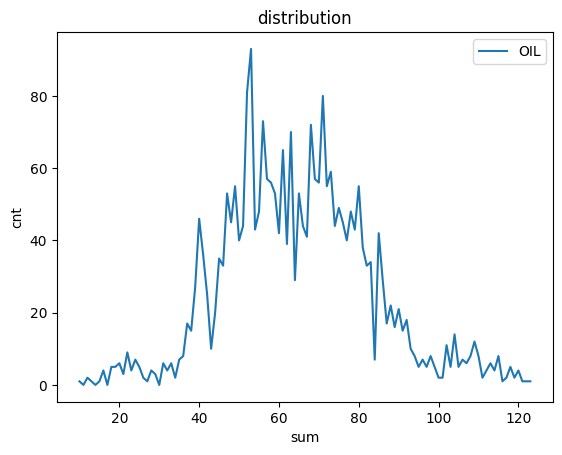

In [33]:
OIL=data['OIL Price Adjusted']
minOIL=OIL.min()
maxOIL=OIL.max()
step = 1
xpoints = np.arange(minOIL, maxOIL+step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(OIL, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="OIL")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [34]:
# OIL Price Adjusted
min_val = int(data['OIL Price Adjusted'].min())
max_val = int(data['OIL Price Adjusted'].max())
ranges = list(range(min_val, max_val + 10, 10)) 
data['ranges_OIL Price Adjusted'] = pd.cut(data['OIL Price Adjusted'], bins=ranges, labels=[f"{r}-{r+9}" for r in ranges[:-1]])
# print(data['ranges_OIL Price Adjusted'])
df_ETH_Price = copy.deepcopy(data)

grouped_data = df_ETH_Price.pivot_table( 
    index='ranges_OIL Price Adjusted',
    values=['OIL Price Adjusted', 'Target Value'], 
    
    aggfunc={'OIL Price Adjusted': 'count', 'Target Value': ['sum', 'mean']}, )

print(grouped_data)


print("------Consolidation of variables------")


df["OIL_final_range"]= np.where(df["OIL Price Adjusted"]<=69,"less69",np.where(df["OIL Price Adjusted"] > 100,"grater100","69-100"))
df_new2=df.loc[:,["OIL Price Adjusted","OIL_final_range"]]
df_new2.head(200)

df_OIL_final_range = (
    df.pivot_table(
        index='OIL_final_range',
        values=['OIL Price Adjusted', 'Target Value'],
                aggfunc={'OIL Price Adjusted': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_OIL_final_range)

                          OIL Price Adjusted Target Value     
                                       count         mean  sum
ranges_OIL Price Adjusted                                     
10-19                                     19     0.315789    6
20-29                                     44     0.409091   18
30-39                                     92     0.217391   20
40-49                                    358     0.382682  137
50-59                                    588     0.314626  185
60-69                                    512     0.376953  193
70-79                                    519     0.229287  119
80-89                                    293     0.197952   58
90-99                                    102     0.235294   24
100-109                                   72     0.305556   22
110-119                                   42     0.309524   13
120-129                                    7     0.428571    3
------Consolidation of variables------
  OIL_final_rang

C:\Users\user1\AppData\Local\Temp\ipykernel_106608\3796156222.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_ETH_Price.pivot_table(


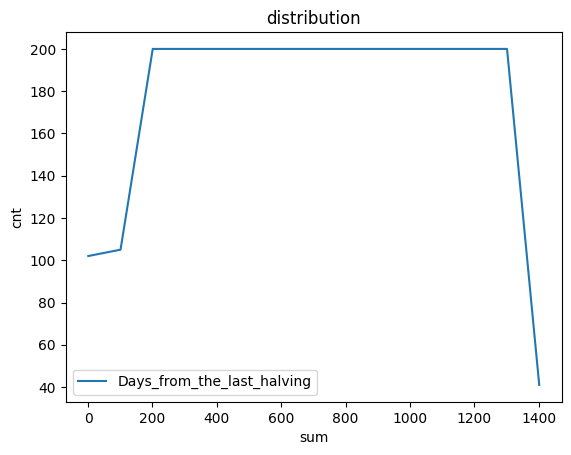

In [35]:
Days_from_the_last_halving=data['Days from the last halving']
minDAYS=Days_from_the_last_halving.min()
maxDAYS=Days_from_the_last_halving.max()
step = 100
xpoints = np.arange(minDAYS, maxDAYS+step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(Days_from_the_last_halving, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="Days_from_the_last_halving")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [36]:
min_val = int(data['Days from the last halving'].min())
max_val = int(data['Days from the last halving'].max())
ranges = list(range(min_val, max_val + 200, 200)) 
data['ranges_Days from the last halving'] = pd.cut(data['Days from the last halving'], bins=ranges, labels=[f"{r}-{r+199}" for r in ranges[:-1]])
# print(data['ranges_OIL Price Adjusted'])
df_Days_from_the_last_halving = copy.deepcopy(data)

grouped_data = df_Days_from_the_last_halving.pivot_table( 
    index='ranges_Days from the last halving',
    values=['Days from the last halving', 'Target Value'], 
    
    aggfunc={'Days from the last halving': 'count', 'Target Value': ['sum', 'mean']}, )

print(grouped_data)

                                  Days from the last halving Target Value     
                                                       count         mean  sum
ranges_Days from the last halving                                             
1-200                                                    207     0.198068   41
201-400                                                  400     0.430000  172
401-600                                                  400     0.437500  175
601-800                                                  400     0.325000  130
801-1000                                                 400     0.180000   72
1001-1200                                                400     0.242500   97
1201-1400                                                400     0.237500   95
1401-1600                                                 39     0.410256   16


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\2457382036.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_Days_from_the_last_halving.pivot_table(


In [37]:
print("------Consolidation of variables------")


data["Days__final_range"]= np.where(data["Days from the last halving"]<=200,"less200",np.where(data["Days from the last halving"] < 800,"200-800",np.where(data["Days from the last halving"]<=1400,"800-1400","greater1400")))
df_new2=data.loc[:,["Days from the last halving","Days__final_range"]]
df_new2.head(200)

df_Days__final_range = (
    data.pivot_table(
        index='Days__final_range',
        values=['Days from the last halving', 'Target Value'],
                aggfunc={'Days from the last halving': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_Days__final_range)

------Consolidation of variables------
  Days__final_range Days from the last halving Target Value     
                                         count         mean  sum
0           200-800                       1198     0.398164  477
1          800-1400                       1202     0.219634  264
2       greater1400                         41     0.414634   17
3           less200                        207     0.193237   40


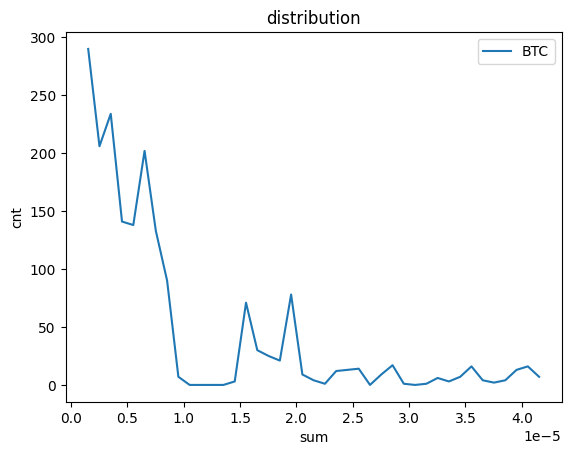

In [38]:
BTC=data['BTC_Hashprice']
minBTC=BTC.min()
maxBTC=BTC.max()
step = 0.000001
xpoints = np.arange(minBTC, maxBTC+step,step) #כל הספרות בדילוגים של 1
hist, bins = np.histogram(BTC, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="BTC")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [39]:
# float/int
min_val_hash = float(data['BTC_Hashprice'].min())
max_val_hash = float(data['BTC_Hashprice'].max())
print(min_val_hash)
print(max_val_hash)
hash=np.arange(min_val_hash, max_val_hash + 0.000001, 0.000001) 
data['ranges_BTC_Hashprice'] = pd.cut(data['BTC_Hashprice'], bins=ranges, labels=[f"{r}-{r+(-0.999999)}" for r in ranges[:-1]])
# print(data['ranges_BTC_Hashprice'])

# min_val_hash = np.min(data['BTC_Hashprice'])
# max_val_hash = np.max(data['BTC_Hashprice'])
# hash = np.arange(min_val_hash, max_val_hash + 0.000009, 0.000009)
# labels = [f"{r}-{r+0.000009}" for r in hash[:-1]]
# data['ranges_BTC_Hashprice'] = pd.cut(data['BTC_Hashprice'], bins=hash, labels=labels)
# # print(data['ranges_BTC_Hashprice'])
df_BTC_Hashprice = copy.deepcopy(data)

# חישוב סטטיסטיקות עבור כל טווח
grouped_data = df_BTC_Hashprice.pivot_table( 
    index='ranges_BTC_Hashprice',
    values=['BTC_Hashprice', 'Target Value'], 
    
    aggfunc={'BTC_Hashprice': 'count', 'Target Value': ['sum', 'mean']}, )

# הצגת הטבלה
print(grouped_data)

1.53e-06
4.229e-05
                         BTC_Hashprice Target Value
                                 count          sum
ranges_BTC_Hashprice                               
1-1.0000000000287557e-06             0            0
201-200.000001                       0            0
401-400.000001                       0            0
601-600.000001                       0            0
801-800.000001                       0            0
1001-1000.000001                     0            0
1201-1200.000001                     0            0
1401-1400.000001                     0            0


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\640170321.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_BTC_Hashprice.pivot_table(


In [40]:
df_hashprice_no_nan= df.loc[:, ['BTC_Hashprice', 'Target Value']].dropna()

df_hashprice_no_nan["BTC_Hashprice_final_range"]= np.where(df_hashprice_no_nan["BTC_Hashprice"]<=63,"less63",np.where(df_hashprice_no_nan["BTC_Hashprice"] > 103,"grater103","63-103"))
df_new=df_hashprice_no_nan.loc[:,["BTC_Hashprice","BTC_Hashprice_final_range"]]
df_new.head(100)

# יצירת טבלת ציר עם df_Crypto_no_nan
BTC_Hashprice_final_range = (
    df_hashprice_no_nan.pivot_table(
        index='BTC_Hashprice_final_range',
        values=['BTC_Hashprice', 'Target Value'],
        aggfunc={'BTC_Hashprice': 'count','Target Value': ['sum', 'mean']},
    ).reset_index()
)

# הצגת הטבלה החדשה
print(BTC_Hashprice_final_range)

  BTC_Hashprice_final_range BTC_Hashprice Target Value     
                                    count         mean  sum
0                    less63          1828     0.271335  496


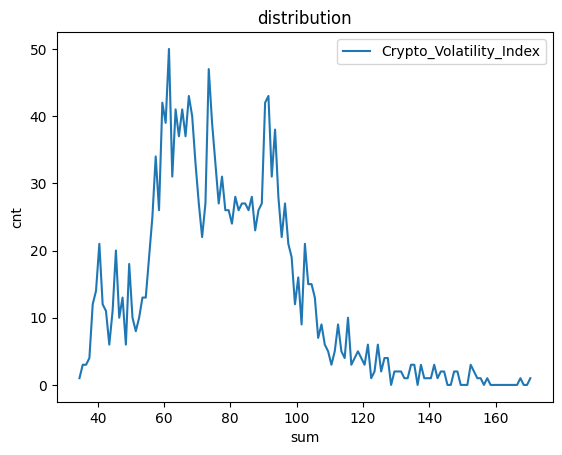

In [41]:
Crypto_Volatility_Index=data['Crypto Volatility Index']
minCrypto_Volatility_Index=Crypto_Volatility_Index.min()
maxCrypto_Volatility_Index=Crypto_Volatility_Index.max()
step = 1
xpoints = np.arange(minCrypto_Volatility_Index, maxCrypto_Volatility_Index+step,step) 
hist, bins = np.histogram(Crypto_Volatility_Index, bins=xpoints)
plt.plot(xpoints[:-1], hist,label="Crypto_Volatility_Index")
plt.title("distribution")
plt.xlabel("sum")
plt.ylabel("cnt")
plt.legend()
plt.show()

In [42]:
# Crypto

min_val = int(data['Crypto Volatility Index'].min())
max_val = int(data['Crypto Volatility Index'].max())
ranges = list(range(min_val, max_val + 10,10))
data['ranges_Crypto_Volatility_Index'] = pd.cut(
    data['Crypto Volatility Index'], bins=ranges, labels=[f"{r}-{r+9}" for r in ranges[:-1]]
)
# print(data.ranges_Crypto_Volatility_Index)
df_Crypto = data.copy()


grouped_data = (
    df_Crypto.pivot_table(
        index='ranges_Crypto_Volatility_Index',
        values=['Crypto Volatility Index', 'Target Value'],
                aggfunc={'Crypto Volatility Index': 'count','Target Value': ['sum', 'mean']},
    ).reset_index()
)

print(grouped_data)

   ranges_Crypto_Volatility_Index Crypto Volatility Index Target Value    
                                                    count         mean sum
0                           34-43                      85     0.082353   7
1                           44-53                     113     0.115044  13
2                           54-63                     307     0.162866  50
3                           64-73                     343     0.212828  73
4                           74-83                     307     0.270358  83
5                           84-93                     307     0.315961  97
6                          94-103                     198     0.378788  75
7                         104-113                      85     0.505882  43
8                         114-123                      41     0.512195  21
9                         124-133                      24     0.541667  13
10                        134-143                      18     0.555556  10
11                       

C:\Users\user1\AppData\Local\Temp\ipykernel_106608\311831447.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Crypto.pivot_table(


In [43]:
df_Crypto_no_nan= df.loc[:, ['Crypto Volatility Index', 'Target Value']].dropna()

df_Crypto_no_nan["crypto_volatility_final_range"]= np.where(df_Crypto_no_nan["Crypto Volatility Index"]<=63,"less63",np.where(df_Crypto_no_nan["Crypto Volatility Index"] > 103,"grater103","63-103"))
df_new=df_Crypto_no_nan.loc[:,["Crypto Volatility Index","crypto_volatility_final_range"]]
df_new.head(100)

# יצירת טבלת ציר עם df_Crypto_no_nan
df_Crypto_volatility_final_range = (
    df_Crypto_no_nan.pivot_table(
        index='crypto_volatility_final_range',
        values=['Crypto Volatility Index', 'Target Value'],
        aggfunc={'Crypto Volatility Index': 'count','Target Value': ['sum', 'mean']},
    ).reset_index()
)

# הצגת הטבלה החדשה
print(df_Crypto_volatility_final_range)

  crypto_volatility_final_range Crypto Volatility Index Target Value     
                                                  count         mean  sum
0                        63-103                    1164     0.281787  328
1                     grater103                     207     0.507246  105
2                        less63                     474     0.132911   63


In [44]:
print(" 1)price")
df_Price_final_range = (
    data.pivot_table(
        index='Price_final_range',
        values=['Price', 'Target Value'],
                aggfunc={'Price': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_Price_final_range)

 1)price
  Price_final_range Price Target Value     
                    count         mean  sum
0       24999-45000   619     0.258481  160
1       grater45000   318     0.336478  107
2         less24999  1711     0.310345  531


In [45]:
print("2) Vol")
Vol_final_range = (
    data.pivot_table(
        index='Vol_final_range',
        values=['Vol.', 'Target Value'],
                aggfunc={'Vol.': 'count','Target Value': ['sum', 'mean']},).reset_index())
# # הצג את הטבלה החדשה
print(Vol_final_range)

2) Vol
  Vol_final_range Target Value       Vol.
                          mean  sum count
0         400-600     0.187943   53   282
1       getter600     0.374517   97   259
2         less400     0.307546  648  2107


In [46]:
print("3) SNP")
df_SNP_Adjusted_final_range = (
    df.pivot_table(
        index='SN&P_Adjusted_final_range',
        values=['SN&P Adjusted', 'Target Value'],
                aggfunc={'SN&P Adjusted': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_SNP_Adjusted_final_range)


3) SNP
  SN&P_Adjusted_final_range SN&P Adjusted Target Value     
                                    count         mean  sum
0                grater2690          2129     0.267262  569
1                  less2690           519     0.441233  229


In [47]:
print ("4)DXY")
min_val = int(data['DXY Adjusted'].min())
max_val = int(data['DXY Adjusted'].max())
ranges = list(range(min_val, max_val + 10, 10)) 
data['ranges_DXY_Adjusted'] = pd.cut(data['DXY Adjusted'], bins=ranges, labels=[f"{r}-{r+1}" for r in ranges[:-1]])
# print(data['ranges_DXY_Adjusted']) 
df_DXY_Adjusted = copy.deepcopy(data)

grouped_data = df_DXY_Adjusted.pivot_table( 
    index='ranges_DXY_Adjusted',
    values=['DXY Adjusted', 'Target Value'], 
    
    aggfunc={'DXY Adjusted': 'count', 'Target Value': ['sum', 'mean']}, )

# הצגת 
print(grouped_data)

4)DXY
                    DXY Adjusted Target Value     
                           count         mean  sum
ranges_DXY_Adjusted                               
88-89                       1675     0.346269  580
98-99                        888     0.228604  203
108-109                       85     0.176471   15


C:\Users\user1\AppData\Local\Temp\ipykernel_106608\3055128241.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped_data = df_DXY_Adjusted.pivot_table(


In [48]:
print ("5) Gold")
df_GOLD_Adjusted_final_range = data.pivot_table(
    index='GOLD_Adjusted_final_rangee',
    values=['GOLD Adjusted', 'Target Value'],
    aggfunc={'GOLD Adjusted': 'count', 'Target Value': ['sum', 'mean']}
).reset_index()

print(df_GOLD_Adjusted_final_range)

5) Gold
  GOLD_Adjusted_final_rangee GOLD Adjusted Target Value     
                                     count         mean  sum
0                  1437-2973          1674     0.258662  433
1                greater2937            53     0.377358   20
2                   less1437           921     0.374593  345


In [49]:
print("6) ETH Price")

df_ETH_Price_final_range = (
    df.pivot_table(
        index='ETH_Price_final_range',
        values=['ETH Price', 'Target Value'],
                aggfunc={'ETH Price': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_ETH_Price_final_range)

6) ETH Price
  ETH_Price_final_range ETH Price Target Value     
                            count         mean  sum
0             1009-4509      1209     0.271299  328
1            grater1474        17     0.176471    3
2              less1009      1422     0.328411  467


In [50]:
print("7) ETH_Vol")

df_ETH_Vol_final_range = (
    data.pivot_table(
        index='ETH_Vol_final_range',
        values=['ETH Vol.', 'Target Value'],
                aggfunc={'ETH Vol.': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_ETH_Vol_final_range)

7) ETH_Vol
  ETH_Vol_final_range ETH Vol. Target Value     
                         count         mean  sum
0             100-500      614     0.148208   91
1           grater500      622     0.369775  230
2             less100     1412     0.337819  477


In [51]:
print( "8) OIL")

df_OIL_final_range = (
    df.pivot_table(
        index='OIL_final_range',
        values=['OIL Price Adjusted', 'Target Value'],
                aggfunc={'OIL Price Adjusted': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_OIL_final_range)

8) OIL
  OIL_final_range OIL Price Adjusted Target Value     
                               count         mean  sum
0          69-100                971     0.217302  211
1       grater100                121     0.314050   38
2          less69               1556     0.352828  549


In [52]:
print("9) Days from the last halving")
df_Days__final_range = (
    data.pivot_table(
        index='Days__final_range',
        values=['Days from the last halving', 'Target Value'],
                aggfunc={'Days from the last halving': 'count','Target Value': ['sum', 'mean']},).reset_index())
# הצג את הטבלה החדשה
print(df_Days__final_range)

9) Days from the last halving
  Days__final_range Days from the last halving Target Value     
                                         count         mean  sum
0           200-800                       1198     0.398164  477
1          800-1400                       1202     0.219634  264
2       greater1400                         41     0.414634   17
3           less200                        207     0.193237   40


In [53]:
print ("10) BTC_Hashprice")

10) BTC_Hashprice


In [54]:
print("11) Crypto Volatility Index")
df_Crypto_volatility_final_range = (
    df_Crypto_no_nan.pivot_table(
        index='crypto_volatility_final_range',
        values=['Crypto Volatility Index', 'Target Value'],
        aggfunc={'Crypto Volatility Index': 'count','Target Value': ['sum', 'mean']},
    ).reset_index()
)

# הצגת הטבלה החדשה
print(df_Crypto_volatility_final_range)

11) Crypto Volatility Index
  crypto_volatility_final_range Crypto Volatility Index Target Value     
                                                  count         mean  sum
0                        63-103                    1164     0.281787  328
1                     grater103                     207     0.507246  105
2                        less63                     474     0.132911   63


In [55]:
df_final=data.loc[:,["Price","Vol.","SN&P Adjusted","DXY Adjusted","GOLD Adjusted","ETH Price","ETH Vol.","OIL Price Adjusted","Days from the last halving"]]

In [56]:
# df_final=df_final.set_index("Price",inplace=True)

In [57]:
print(df_final)

      Price    Vol.  SN&P Adjusted  DXY Adjusted  GOLD Adjusted  ETH Price  \
0     64902   45.17        4953.56       105.984        2390.45    3169.62   
1     64961   49.33        4953.56       105.984        2390.45    3156.63   
2     63799  150.34        4953.56       105.984        2390.45    3056.23   
3     63481   97.38        5001.89       105.982        2378.25    3064.48   
4     61278  118.92        5007.25       105.764        2360.81    2985.82   
...     ...     ...            ...           ...            ...        ...   
2643    894   37.90        2288.90       100.252        1200.31      10.48   
2644    893   58.87        2266.70       100.058        1208.81      10.50   
2645    921   32.74        2257.00       100.125        1217.48      10.77   
2646    918   47.93        2257.00       100.125        1217.48      10.64   
2647    919   40.38        2257.00       100.125        1217.48      10.95   

      ETH Vol.  OIL Price Adjusted  Days from the last halving 

In [58]:
print(df_final)

      Price    Vol.  SN&P Adjusted  DXY Adjusted  GOLD Adjusted  ETH Price  \
0     64902   45.17        4953.56       105.984        2390.45    3169.62   
1     64961   49.33        4953.56       105.984        2390.45    3156.63   
2     63799  150.34        4953.56       105.984        2390.45    3056.23   
3     63481   97.38        5001.89       105.982        2378.25    3064.48   
4     61278  118.92        5007.25       105.764        2360.81    2985.82   
...     ...     ...            ...           ...            ...        ...   
2643    894   37.90        2288.90       100.252        1200.31      10.48   
2644    893   58.87        2266.70       100.058        1208.81      10.50   
2645    921   32.74        2257.00       100.125        1217.48      10.77   
2646    918   47.93        2257.00       100.125        1217.48      10.64   
2647    919   40.38        2257.00       100.125        1217.48      10.95   

      ETH Vol.  OIL Price Adjusted  Days from the last halving 

In [59]:
df_final["TV"]=data["Target Value"].shift(-1)

In [60]:
# print(df_final)

In [61]:
df_final=df_final.dropna()

In [62]:
df_final["TV"] = df_final["TV"].apply(int)

In [63]:
print(df_final)

      Price    Vol.  SN&P Adjusted  DXY Adjusted  GOLD Adjusted  ETH Price  \
0     64902   45.17        4953.56       105.984        2390.45    3169.62   
1     64961   49.33        4953.56       105.984        2390.45    3156.63   
2     63799  150.34        4953.56       105.984        2390.45    3056.23   
3     63481   97.38        5001.89       105.982        2378.25    3064.48   
4     61278  118.92        5007.25       105.764        2360.81    2985.82   
...     ...     ...            ...           ...            ...        ...   
2642    915   33.80        2294.10       100.266        1188.57      10.63   
2643    894   37.90        2288.90       100.252        1200.31      10.48   
2644    893   58.87        2266.70       100.058        1208.81      10.50   
2645    921   32.74        2257.00       100.125        1217.48      10.77   
2646    918   47.93        2257.00       100.125        1217.48      10.64   

      ETH Vol.  OIL Price Adjusted  Days from the last halving 

In [64]:
df_final["TV2"]=df_final["Price"].shift(-1)

In [65]:
df_final=df_final.dropna()

In [66]:
print(df_final)

      Price    Vol.  SN&P Adjusted  DXY Adjusted  GOLD Adjusted  ETH Price  \
0     64902   45.17        4953.56       105.984        2390.45    3169.62   
1     64961   49.33        4953.56       105.984        2390.45    3156.63   
2     63799  150.34        4953.56       105.984        2390.45    3056.23   
3     63481   97.38        5001.89       105.982        2378.25    3064.48   
4     61278  118.92        5007.25       105.764        2360.81    2985.82   
...     ...     ...            ...           ...            ...        ...   
2641    918   30.97        2291.60       100.281        1191.60      10.50   
2642    915   33.80        2294.10       100.266        1188.57      10.63   
2643    894   37.90        2288.90       100.252        1200.31      10.48   
2644    893   58.87        2266.70       100.058        1208.81      10.50   
2645    921   32.74        2257.00       100.125        1217.48      10.77   

      ETH Vol.  OIL Price Adjusted  Days from the last halving 

In [67]:
df_final.reset_index()

,index,Price,Vol.,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,ETH Vol.,OIL Price Adjusted,Days from the last halving,TV,TV2
0,0,64902,45.17,4953.56,105.984,2390.45,3169.62,276.66,83.14,2,0,64961.0
1,1,64961,49.33,4953.56,105.984,2390.45,3156.63,256.05,83.14,1,0,63799.0
2,2,63799,150.34,4953.56,105.984,2390.45,3056.23,645.65,83.14,1439,1,63481.0
3,3,63481,97.38,5001.89,105.982,2378.25,3064.48,423.99,82.73,1438,1,61278.0
4,4,61278,118.92,5007.25,105.764,2360.81,2985.82,524.88,82.69,1437,0,63805.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2641,2641,918,30.97,2291.60,100.281,1191.60,10.50,61.25,53.17,202,0,915.0
2642,2642,915,33.80,2294.10,100.266,1188.57,10.63,84.72,53.78,201,0,894.0
2643,2643,894,37.90,2288.90,100.252,1200.31,10.48,26.19,52.75,200,1,893.0
2644,2644,893,58.87,2266.70,100.058,1208.81,10.50,105.21,53.18,199,0,921.0


In [68]:


# Load dataset
data = df_final  # Replace with your dataset path

# Prepare features and target
X = data.drop(['TV','TV2'], axis=1)  # Replace 'target_column' with your target column name
y = data['TV2']  # Replace with your target column name

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

Accuracy: 0.0018867924528301887
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
Classification Report:
              precision    recall  f1-score   support

       918.0       0.00      0.00      0.00         1
       982.0       0.00      0.00      0.00         1
      1013.0       0.00      0.00      0.00         1
      1031.0       0.00      0.00      0.00         1
      1041.0       0.00      0.00      0.00         1
      1044.0       0.00      0.00      0.00         2
      1049.0       0.00      0.00      0.00         1
      1119.0       0.00      0.00      0.00         1
      1147.0       0.00      0.00      0.00         0
      1172.0       0.00      0.00      0.00         1
      1176.0       0.00      0.00      0.00         1
      1180.0       0.00      0.00      0.00         1
      1188.0       0.00      0.00      0.00         1
      1194.0       0.00      0.00      0.00       

c:\Users\user1\Desktop\תמי\תכנות\python\crypto\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user1\Desktop\תמי\תכנות\python\crypto\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user1\Desktop\תמי\תכנות\python\crypto\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

In [69]:
# Assuming your data is in a CSV file named 'your_data.csv'
data = df_final
X = data.drop(['TV', 'TV2'], axis=1)  # Drop unnecessary columns
y = data['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1249049.61601566
R-squared: 0.9957474010380721


In [70]:
import math
sqrt_number = math.sqrt(1249049.61601566)
print(f"השורש הריבועי של {1249049.61601566} הוא {sqrt_number}")

השורש הריבועי של 1249049.61601566 הוא 1117.6088832931046


In [71]:
# קרא את הנתונים שלך (הנחת קובץ CSV לדוגמה)
data = df_final

# הנחה שעמודת ה-TARGET שלך נקראת 'target'
X = data.drop('TV', axis=1)
y = data['TV']

# חלוקת הנתונים לסט אימון וסט בדיקה (לא חובה, אבל מומלץ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# יישום SMOTE כדי לאזן את סט האימון
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Original dataset shape:", y_train.value_counts())
print("Balanced dataset shape:", y_train_balanced.value_counts())

# עכשיו הנתונים שלך מאוזנים וניתן להשתמש בהם להכשרת המודל שלך


Original dataset shape: TV
0    1480
1     636
Name: count, dtype: int64
Balanced dataset shape: TV
0    1480
1    1480
Name: count, dtype: int64


In [72]:
# יצירת DataFrame חדש עבור הנתונים המאוזנים
balanced_data = pd.DataFrame(X_train_balanced, columns=X_train.columns)
balanced_data['TV'] = y_train_balanced

# שמירת הנתונים המאוזנים לקובץ חדש (CSV לדוגמה)
balanced_data.to_csv('balanced_dataset.csv', index=False)

# במידה ורוצים לאחד עם סט הבדיקה לדטהסט חדש
balanced_dataset = pd.concat([balanced_data, pd.concat([X_test, y_test], axis=1)], ignore_index=True)
balanced_dataset.to_csv('complete_balanced_dataset.csv', index=False)

print("Balanced dataset saved to 'balanced_dataset.csv'")
print("Complete dataset (balanced train + original test) saved to 'complete_balanced_dataset.csv'")


Balanced dataset saved to 'balanced_dataset.csv'
Complete dataset (balanced train + original test) saved to 'complete_balanced_dataset.csv'


In [73]:
data = balanced_dataset  # Replace with your dataset path

X = data.drop('TV', axis=1)  # Replace 'target_column' with your target column name
y = data['TV']  # Replace with your target column name

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

Accuracy: 0.5616045845272206
Confusion Matrix:
[[288  93]
 [213 104]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.76      0.65       381
           1       0.53      0.33      0.40       317

    accuracy                           0.56       698
   macro avg       0.55      0.54      0.53       698
weighted avg       0.55      0.56      0.54       698



c:\Users\user1\Desktop\תמי\תכנות\python\crypto\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
# Assuming your data is in a CSV file named 'your_data.csv'
data = balanced_dataset
X = data.drop('TV', axis=1)
y = data['TV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.18766246418338112
R-squared: 0.24298580690032034


In [75]:
#Calculate correlation
correlation = df_final['Price'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.9984788890684465


In [76]:
correlation = df_final['Vol.'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: -0.314951090707138


In [77]:
correlation = df_final['SN&P Adjusted'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.8924460593754456


In [78]:
correlation = df_final['DXY Adjusted'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.18552178123919885


In [79]:
correlation = df_final['GOLD Adjusted'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.7440600332722328


In [80]:
correlation = df_final['ETH Price'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.9352203451454735


In [81]:
correlation = df_final['ETH Vol.'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.25519200393602726


In [82]:
correlation = df_final['OIL Price Adjusted'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.5265889545612743


In [83]:
correlation = df_final['Days from the last halving'].corr(df_final['TV2'])
print("Correlation:", correlation)

Correlation: 0.07618624628866964


In [84]:
# 3 data frame without fetures with weakest correlation
df_final_1=data.loc[:,["Price","Vol.","SN&P Adjusted","DXY Adjusted","GOLD Adjusted","ETH Price","ETH Vol.","OIL Price Adjusted"]]
df_final_2=data.loc[:,["Price","Vol.","SN&P Adjusted","DXY Adjusted","GOLD Adjusted","ETH Price","OIL Price Adjusted", "Days from the last halving"]]
df_final_3=data.loc[:,["Price","Vol.","SN&P Adjusted","GOLD Adjusted","ETH Price","ETH Vol.","OIL Price Adjusted", "Days from the last halving"]]

In [85]:
df_final_1["TV2"]=df_final["Price"].shift(-1)

In [86]:
df_final_1=df_final.dropna()

In [87]:
# data frame one without "Days_from_the_last_halving"
data_1 = df_final_1
X = data_1.drop(['TV', 'TV2'], axis=1)  # Drop unnecessary columns
y = data_1['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1249049.61601566
R-squared: 0.9957474010380721


In [88]:
df_final_2["TV2"]=df_final["Price"].shift(-1)

In [89]:
df_final_2=df_final.dropna()

In [90]:
# data frame one without "ETH Vol."
data_2 = df_final_2
X = data_2.drop(['TV2'], axis=1)  # Drop unnecessary columns
y = data_2['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1254568.499438113
R-squared: 0.9957286110735964


In [91]:
df_final_3["TV2"]=df_final["Price"].shift(-1)

In [92]:
df_final_3=df_final.dropna()

In [93]:
# data frame one without "DXY"
data_3 = df_final_3
X = data_3.drop(['TV2'], axis=1)  # Drop unnecessary columns
y = data_3['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1254568.499438113
R-squared: 0.9957286110735964


In [94]:
df_final_4=data.loc[:,["Price","Vol.","SN&P Adjusted","GOLD Adjusted","ETH Price","OIL Price Adjusted"]]

In [95]:
df_final_4["TV2"]=df_final["Price"].shift(-1)

In [96]:
data_4 = df_final
data_4 = data_4.dropna(subset=['TV2'])
X = data_4.drop(['TV2'], axis=1)
y = data_4['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1254568.499438113
R-squared: 0.9957286110735964


In [97]:
df_final_co=df_final.drop(["TV","TV2"], axis=1)

In [98]:
correlations = {}

In [99]:
df_final_co.head()

,Price,Vol.,SN&P Adjusted,DXY Adjusted,GOLD Adjusted,ETH Price,ETH Vol.,OIL Price Adjusted,Days from the last halving
0,64902,45.17,4953.56,105.984,2390.45,3169.62,276.66,83.14,2
1,64961,49.33,4953.56,105.984,2390.45,3156.63,256.05,83.14,1
2,63799,150.34,4953.56,105.984,2390.45,3056.23,645.65,83.14,1439
3,63481,97.38,5001.89,105.982,2378.25,3064.48,423.99,82.73,1438
4,61278,118.92,5007.25,105.764,2360.81,2985.82,524.88,82.69,1437


In [100]:
for param in df_final_co:
    correlations[param] = {}
    for other_param in df_final_co:
        if param != other_param:
            correlation = df_final_co[param].corr(df_final_co[other_param])
            correlations[param][other_param] = correlation


In [101]:
for param, corr in correlations.items():
    for other_param, value in corr.items():
        correlation_df = pd.DataFrame(correlations)
print(correlation_df)

                               Price      Vol.  SN&P Adjusted  DXY Adjusted  \
Vol.                       -0.316202       NaN      -0.260251      0.019299   
SN&P Adjusted               0.892462 -0.260251            NaN      0.443701   
DXY Adjusted                0.184601  0.019299       0.443701           NaN   
GOLD Adjusted               0.744421 -0.189021       0.883423      0.422473   
ETH Price                   0.934978 -0.338168       0.881694      0.247401   
ETH Vol.                    0.256124 -0.268795       0.254120      0.176039   
OIL Price Adjusted          0.524675 -0.196665       0.633137      0.575840   
Days from the last halving  0.076122  0.198030       0.248192      0.612368   
Price                            NaN -0.316202       0.892462      0.184601   

                            GOLD Adjusted  ETH Price  ETH Vol.  \
Vol.                            -0.189021  -0.338168 -0.268795   
SN&P Adjusted                    0.883423   0.881694  0.254120   
DXY Adjuste

In [102]:
correlation = df_final['Days from the last halving'].corr(df_final['ETH Price'])
print("Correlation:", correlation)

Correlation: 0.07517354474253866


In [103]:
df_final_5=df_final.drop(["SN&P Adjusted"], axis=1)

In [104]:
data_5 = df_final_5
X = data_5.drop(['TV2'], axis=1)
y = data_5['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1283283.162054717
R-squared: 0.9956308471874628


In [105]:
df_final_6=df_final.drop(["GOLD Adjusted"], axis=1)

In [106]:
data_6 = df_final_6
X = data_6.drop(['TV2'], axis=1)
y = data_6['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1250771.788246415
R-squared: 0.9957415376137959


In [107]:
df_final_7=df_final.drop(["ETH Price"], axis=1)

In [108]:
data_7 = df_final_7
X = data_7.drop(['TV2'], axis=1)
y = data_7['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1267134.8142962265
R-squared: 0.9956858269465004


In [109]:
df_final_8=df_final.drop(["OIL Price Adjusted"], axis=1)

In [110]:
data_8 = df_final_8
X = data_8.drop(['TV2'], axis=1)
y = data_8['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1287838.6350779245
R-squared: 0.9956153373153158


In [111]:
df_final_9=df_final.drop(["Days from the last halving"], axis=1)

In [112]:
data_9 = df_final_9
X = data_9.drop(['TV2'], axis=1)
y = data_9['TV2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 1260466.1528777361
R-squared: 0.9957085315230537


In [113]:
np.random.seed(42)
X = data.drop(['TV2','TV'], axis=1)
y = data['TV2']

In [114]:
x2=data.iloc[[-1]]

In [115]:


# הגדרת מודל SVR עם גרעין לינארי, פולינומי וגרעין RBF
# svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
# svr_poly = SVR(kernel='poly', C=100, degree=3, epsilon=0.1, coef0=1)
svr_lin = SVR(kernel='linear', C=100, epsilon=0.1)


# אימון המודלים על הנתונים
# y_rbf = svr_rbf.fit(X, y).predict(X)
# y_poly = svr_poly.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
